In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker

In [2]:
! radical-stack


  python               : 3.8.6
  pythonpath           : 
  virtualenv           : /Users/mturilli/.virtualenvs/analytics-devel

  radical.analytics    : 1.5.0-v1.5.0-5-g2ad4481@feature-ru-option
  radical.entk         : 1.5.1
  radical.gtod         : 1.5.0
  radical.pilot        : 1.5.4-v1.5.4@devel
  radical.saga         : 1.5.2
  radical.utils        : 1.5.4-v1.5.4@devel



In [3]:
suds = [
        're.session.login2.hrlee.018599.0001',
        're.session.login2.hrlee.018602.0014'
       ] 
sdir = '../data/raw/paper_12122020/'
sids = [sdir+s for s in suds]

In [4]:
%%capture capt

ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})


In [5]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': ss[sid]['ngpus']/6})

In [6]:
info = []
for sid in suds:
    info.append({'session'  : sid,
                 'resource' : ss[sid]['pres'],
                 'pilot_lm' : ss[sid]['lm'], 
                 'pilots'   : ss[sid]['npilot'],
                 'ps_active': ss[sid]['npact'],
                 'cores'    : ss[sid]['ncores']/4, 
                 'gpus'     : ss[sid]['ngpus'], 
                 'nodes'    : ss[sid]['nnodes'], 
                 'tasks'    : ss[sid]['nunit'], 
                 'ts_done'  : ss[sid]['nudone'],  
                 'ts_failed': ss[sid]['nufail']})

df_info = pd.DataFrame(info) 
df_info

,session,resource,pilot_lm,pilots,ps_active,cores,gpus,nodes,tasks,ts_done,ts_failed
0,re.session.login2.hrlee.018599.0001,ornl.summit,JSRUN,1,1,840.0,120,20.0,250,236,0
1,re.session.login2.hrlee.018602.0014,ornl.summit,JSRUN,1,1,6720.0,960,160.0,2000,1984,7


In [7]:
%%capture capt

u_durations = {}

for sid in suds:
    u_durations[sid] = {}

for sid in suds:
    for uid in ss[sid]['u'].list('uid'):
        unit = ss[sid]['u'].get(etype='unit', uid=uid)[0]
        durations = {}
        for k,v in rp.utils.UNIT_DURATIONS_DEBUG.items():
            try:
                durations[k] = unit.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, uid, v))
                durations[k] = 0
        u_durations[sid].update({uid: durations})

In [8]:
%%capture capt

p_durations = {}

for sid in suds:
    p_durations[sid] = {}

for sid in suds:
    for pid in ss[sid]['p'].list('uid'):
        pilot = ss[sid]['p'].get(etype='pilot', uid=pid)[0]
        durations = {}
        for k,v in rp.utils.PILOT_DURATIONS_DEBUG.items():
            try:
                durations[k] = pilot.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, pid, v))
                durations[k] = 0
        p_durations[sid].update({pid: durations})

In [9]:
# With RP < 1.5.2, on Summit, bootstrap_0_stop, cu_pre_start|stop are 
# not recorded. We cannot use the default durations.

for sid in suds:
    w  = ss[sid]['w']
    u  = ss[sid]['u']
    t  = ss[sid]['t']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttx_p': p0.duration(event=[ {ru.EVENT: 'bootstrap_0_start', ru.STATE: None   },
                                 # {ru.EVENT: 'bootstrap_0_stop', ru.STATE: None    }]),
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE    },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED  },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED}]]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None       },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None       } ])})
    
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_p'] - ss[sid]['ttx_u']})

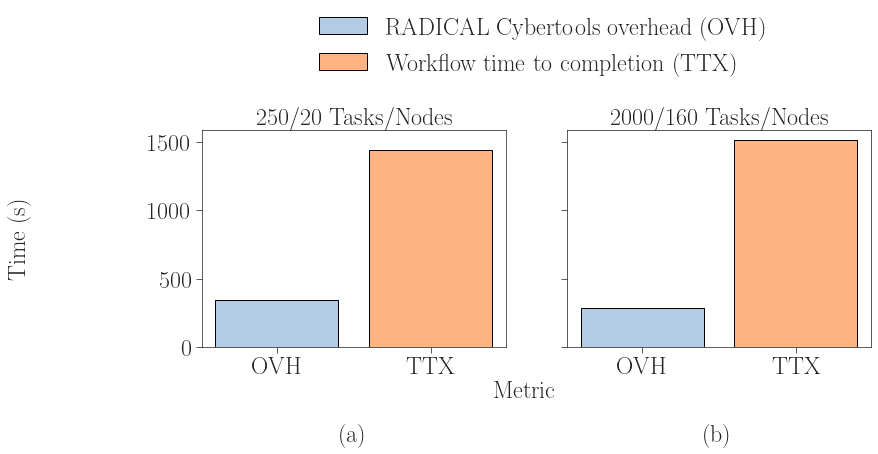

In [10]:
fwidth = 6*len(suds)
fhight = 4
fig, axarr = plt.subplots(1, len(suds), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    if len(suds) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text(-0.1,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text( 0.5, -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.35), fontsize=24, ncol=1)
    
plt.savefig('figures/paper_12122020_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_12122020_ovh_ttx.png', dpi=300, bbox_inches='tight')